In [19]:
#import the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics


random_state = 42

In [20]:
#load the weighted average COI data

coi_district_grouped_data_df = pd.read_csv('data_raw/coi_district_grouped.csv')
coi_district_grouped_data_df.head(5)

,Unnamed: 0,LEAID,NAME_LEA15,year,pop_total,pop_child,ED_APENR,ED_ATTAIN,ED_COLLEGE,ED_ECENROL,...,HE_SUPRFND,HE_RSEI,SE_POVRATE,SE_PUBLIC,SE_HOME,SE_OCC,SE_MHE,SE_EMPRAT,SE_JOBPROX,SE_SINGLE
0,0,100001,Fort Rucker School District,2010,16612,5237,0.002910,22.619878,29.664835,43.445058,...,-13.815511,7.186165,11.497064,10.950494,50.695610,34.471383,51857.44353,57.442524,3.672140,34.361032
1,1,100001,Fort Rucker School District,2015,16612,4517,0.006263,21.259823,29.007108,37.380502,...,-13.815511,4.703871,15.744478,10.710785,52.364315,34.436546,55520.37021,55.735629,2.884125,30.666308
2,2,100003,Maxwell AFB School District,2010,7495,1790,0.397575,16.466437,35.217565,63.588126,...,-13.815511,6.344293,25.240513,17.439483,41.705791,25.227103,52990.02308,45.487064,0.556821,44.548671
3,3,100003,Maxwell AFB School District,2015,7495,1830,0.174263,17.040989,33.162098,27.046712,...,-13.815511,6.839344,25.306492,20.043474,39.789435,31.212198,51959.43095,47.330333,2.319544,51.321166
4,4,100005,Albertville City School District,2010,41010,11292,0.149759,13.036410,23.802690,15.265411,...,-13.815511,6.243141,21.744128,15.909029,66.320894,23.622400,41081.22455,71.665946,7.205905,31.809895


In [21]:
#split the data into two subsets , one for 2010 and the other for 2015 data. One of the goals is to see
#how the school districts' oppurtunity index value changed between the years 2010 and 2015. We eventually used
#2015 data for clustering.
coi_district_grouped_2010_data_df = coi_district_grouped_data_df[coi_district_grouped_data_df['year'] == 2010]
coi_district_grouped_2015_data_df = coi_district_grouped_data_df[coi_district_grouped_data_df['year'] == 2015]


In [22]:
#plot the distribution of the features.Define a re-usable function
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')

    fig.tight_layout()  
    plt.show()

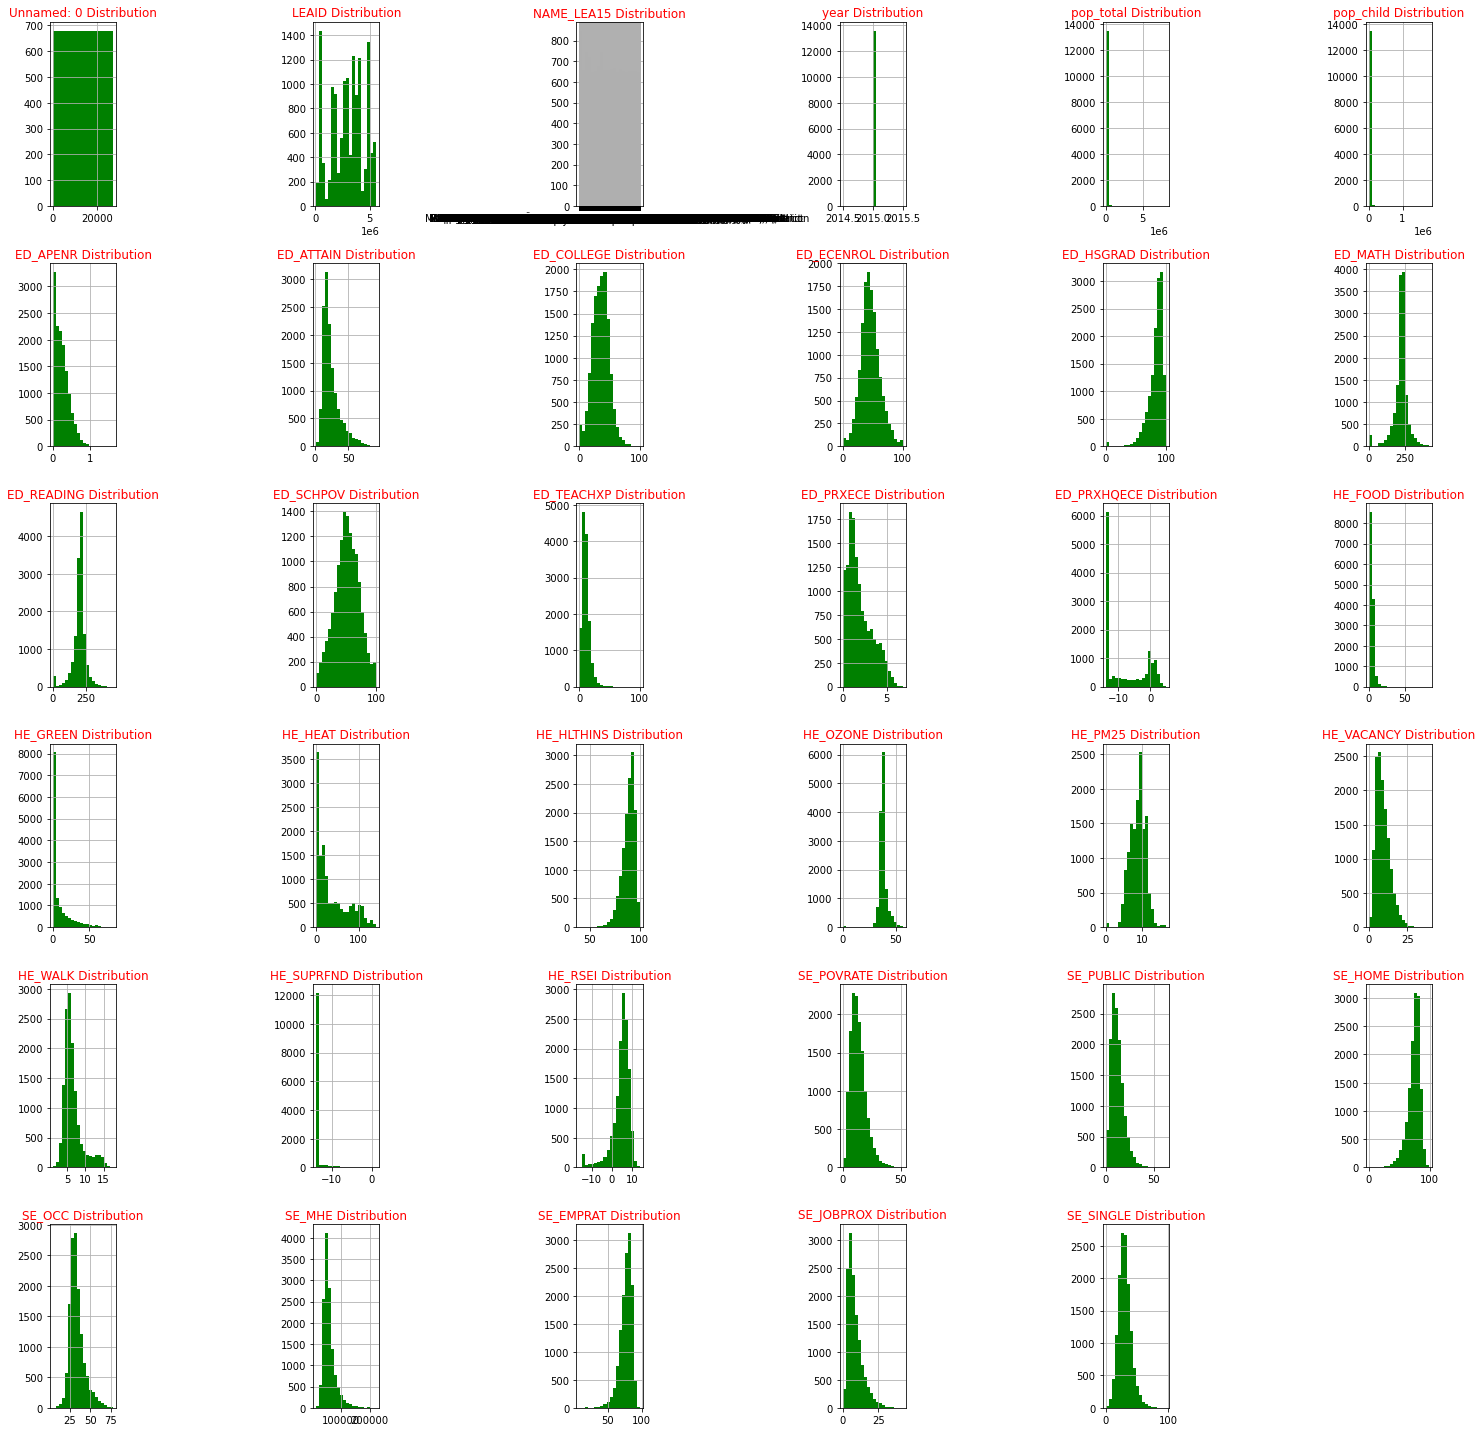

In [23]:
#check the data distribution for the columns in the 2015 data. THe plot takes a few minutes to run, so commented it.

histograms_plot(coi_district_grouped_2015_data_df,coi_district_grouped_2015_data_df.columns,6,6)

In [24]:
#extract the real valued columns into a numpy array. The array will be used to feed into the dimensinality reduction
#and clustering methods later
feature_columns = ['pop_total', 'pop_child',
       'ED_APENR', 'ED_ATTAIN', 'ED_COLLEGE', 'ED_ECENROL', 'ED_HSGRAD',
       'ED_MATH', 'ED_READING', 'ED_SCHPOV', 'ED_TEACHXP', 'ED_PRXECE',
       'ED_PRXHQECE', 'HE_FOOD', 'HE_GREEN', 'HE_HEAT', 'HE_HLTHINS',
       'HE_OZONE', 'HE_PM25', 'HE_VACANCY', 'HE_WALK', 'HE_SUPRFND', 'HE_RSEI',
       'SE_POVRATE', 'SE_PUBLIC', 'SE_HOME', 'SE_OCC', 'SE_MHE', 'SE_EMPRAT',
       'SE_JOBPROX', 'SE_SINGLE']


X_2015_dataset = np.array(coi_district_grouped_2015_data_df[feature_columns])
#Scale the data. 
scaler_2015 = StandardScaler()
X_2015_scaled = scaler_2015.fit_transform(X_2015_dataset)

#this is how the data looks after scaling

X_2015_scaled

array([[-0.16944628, -0.15324915, -1.20088774, ..., -2.24075212,
        -1.03291525,  0.01936115],
       [-0.25111275, -0.25630656, -0.34079291, ..., -3.1750307 ,
        -1.13845032,  2.00380269],
       [ 0.04910132,  0.13828019,  0.61898784, ..., -0.55505656,
        -0.0722572 ,  0.49054952],
       ...,
       [-0.12750679, -0.15639419,  1.6283548 , ...,  1.75544102,
        -1.39216588, -0.35138717],
       [-0.28856449, -0.30436422, -0.2472472 , ..., -0.27866225,
         2.87316832,  0.29305125],
       [-0.24181476, -0.24863575, -0.10166364, ...,  0.21112223,
        -0.8248696 , -0.05760164]])

In [25]:
#run dimensionality reduction on the scaled 2015 data. PCA in particular is sensitive to the data elements' scale
pca_2015 = PCA(random_state=random_state)
pca_2015.fit(X_2015_scaled)
print(pca_2015.explained_variance_ratio_)

[2.74633614e-01 1.38520191e-01 6.67479263e-02 5.75258493e-02
 4.99806758e-02 4.41753633e-02 3.82787880e-02 3.59251695e-02
 3.05131928e-02 2.83691476e-02 2.61604267e-02 2.52696678e-02
 2.25900497e-02 1.98161032e-02 1.71604247e-02 1.61880779e-02
 1.50547283e-02 1.25102162e-02 1.21343193e-02 1.10110596e-02
 1.03321129e-02 9.93079217e-03 8.29267954e-03 6.06124320e-03
 5.55137540e-03 4.58927808e-03 3.74614948e-03 3.43131973e-03
 3.10081009e-03 2.16601859e-03 2.33229660e-04]


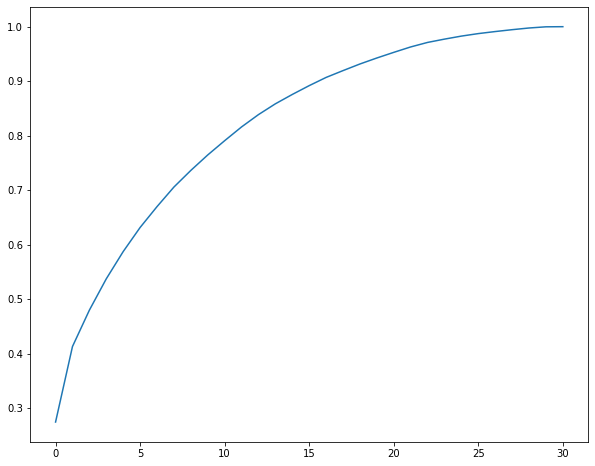

In [26]:
#plot the explained variance against the number of components and pick components that explain atleast 80% of the variance
plt.figure(figsize = (10, 8))
plt.plot(pca_2015.explained_variance_ratio_.cumsum() )#, marker = 'o', linestyle = '--')

In [27]:
#now re-fit the pca on 11 components for 2015 data. The 11 components together contribute to 80% variance
pca_2015 = PCA(n_components = 11, random_state=random_state)
coi_district_grouped_data_tranformed_2015_array = pca_2015.fit_transform(X_2015_scaled)

In [28]:
#check for the optimum number of clusters for k-means for 2015 data
wcss_2015 = [] 
for number_of_clusters in range(1, 30): 
    kmeans_pca_2015 = KMeans(n_clusters = number_of_clusters,n_init = 20, random_state = random_state, algorithm= "auto",max_iter = 1000 ).fit(coi_district_grouped_data_tranformed_2015_array)
    wcss_2015.append(kmeans_pca_2015.inertia_)


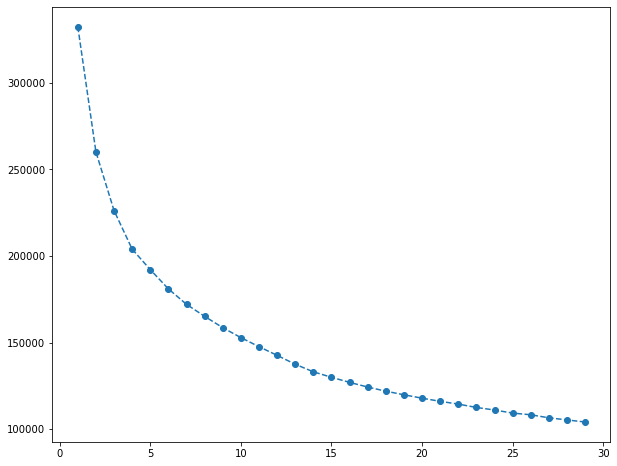

In [29]:
#plot the k-means output for different number of clusters
plt.figure(figsize = (10, 8))
plt.plot(range(1, 30), wcss_2015, marker = 'o', linestyle = '--')
plt.show()

In [30]:
#refit k-means for the optimal number of clusters from the above step.Used 'elbow' method to pick the number of clusters
kmeans_pca_2015 = KMeans(n_clusters = 4,n_init = 20, random_state = random_state, algorithm= "auto",max_iter = 1000 ).fit(coi_district_grouped_data_tranformed_2015_array)


In [31]:
#Combine/Concatenate the orignial COI data and the principal components together for 2010
pca_with_coi_district_grouped_data_df = pd.concat([coi_district_grouped_2015_data_df.reset_index(drop = True), pd.DataFrame(coi_district_grouped_data_tranformed_2015_array)],axis = 1)
pca_with_coi_district_grouped_data_df.columns.values[-11:] = ['Component 1','Component 2','Component 3','Component 4','Component 4','Component 6','Component 7','Component 8','Component 9','Component 10','Component 11']
pca_with_coi_district_grouped_data_df['Segment from k-means PCA'] = kmeans_pca_2015.labels_
#pca_with_coi_district_grouped_data_df.to_csv('pca_with_coi_district_grouped_data_2015.csv')

In [32]:
#look at the data from pca and k-means clustering. The dataframe contains the original COI fields and the 11 principal components
pca_with_coi_district_grouped_data_df.head(5)

,Unnamed: 0,LEAID,NAME_LEA15,year,pop_total,pop_child,ED_APENR,ED_ATTAIN,ED_COLLEGE,ED_ECENROL,...,Component 3,Component 4,Component 4,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Segment from k-means PCA
0,1,100001,Fort Rucker School District,2015,16612,4517,0.006263,21.259823,29.007108,37.380502,...,0.724260,-0.065287,-0.478962,-0.096645,-1.580861,0.005570,0.790871,-1.273687,1.039661,3
1,3,100003,Maxwell AFB School District,2015,7495,1830,0.174263,17.040989,33.162098,27.046712,...,-2.149270,-0.810165,0.287038,-1.877590,-1.158833,-2.371244,-0.777297,-0.670613,0.000623,2
2,5,100005,Albertville City School District,2015,41010,12118,0.361735,16.010862,26.164117,41.136266,...,1.125962,-0.519197,-0.059115,0.188830,0.260779,0.099538,0.157789,0.421024,-0.781577,3
3,7,100006,Marshall County School District,2015,93019,23549,0.435333,17.501746,27.663788,36.003602,...,1.409312,0.178503,0.250409,0.287380,0.438777,-0.196419,-0.076909,0.528833,-0.748437,3
4,9,100007,Hoover City School District,2015,173409,42763,0.524790,54.070326,44.409358,61.091611,...,1.461529,1.011157,0.203841,0.609073,-1.437370,-0.253211,0.429813,0.620559,0.689754,1


c:\Users\jchndra\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



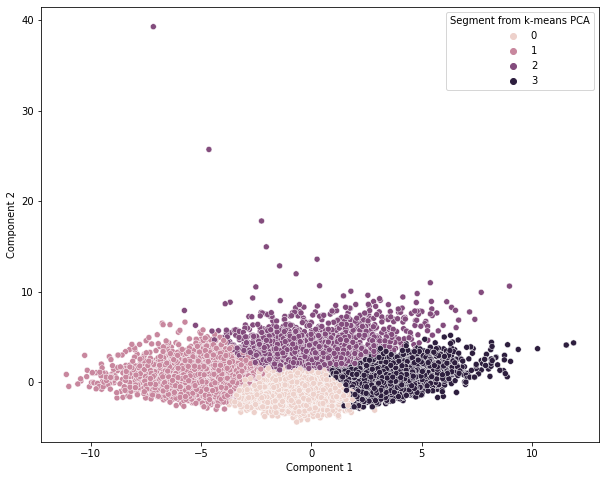

In [33]:
#plot the segments on the first two princial components. The picture below shows clear separation among the 4 clusters!.
x_axis = pca_with_coi_district_grouped_data_df['Component 1']
y_axis = pca_with_coi_district_grouped_data_df['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue=pca_with_coi_district_grouped_data_df['Segment from k-means PCA'])
plt.show()